# Data Preprocessing

In [17]:
%pip install torch torchvision pandas scikit-learn matplotlib
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 28.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 39.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [2]:
#imaget_norm consist of the mean and std of imagenet dataset
imagenet_norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# The following class will be used to preprocess our data
# Every image in our dataset will be resized to 224x224 and converted to tensors
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    imagenet_norm
])




## Loading the dataset

In [3]:
train_data = datasets.ImageFolder(root='./train', transform=transform)
test_data = datasets.ImageFolder(root='./test', transform=transform)
val_data = datasets.ImageFolder(root='./val', transform=transform)


In [4]:
# Load pretrained model
# feature extractor will be used to extract features from our images
resnet = models.resnet18(pretrained=True)
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.eval() 

/home/swesan/repos/pneumonia-detection-pytorch/.conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/swesan/repos/pneumonia-detection-pytorch/.conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
8.1%

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/swesan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [5]:
# Function to extract features
def extract_features(dataset):
    
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features, labels = [], []
    with torch.no_grad():
        for images, y in loader:
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)  
            features.append(outputs.numpy())
            labels.append(y.numpy())
    
    X = np.concatenate(features)
    y = np.concatenate(labels)
    return X, y

In [6]:
# Extract features for all sets
X_train, y_train = extract_features(train_data)
X_val, y_val = extract_features(test_data)
X_test, y_test = extract_features(val_data)

In [9]:
# Convet the dataset to pandas dataframe
import pandas as pd
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
X_val_df = pd.DataFrame(X_val)
y_val_df = pd.DataFrame(y_val)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

In [ ]:
# --- Logistic Regression Baseline ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train
lr_model = LogisticRegression(max_iter=500, solver='lbfgs')
lr_model.fit(X_train_df, y_train_df)

# Evaluate on validation and test sets
for split, (X, y) in {
    "Validation": (X_val_df, y_val_df),
    "Test": (X_test_df, y_test_df)
}.items():
    preds = lr_model.predict(X)
    print(f"{split} Accuracy: {accuracy_score(y, preds):.4f}")
    print(f"{split} Report:\n", classification_report(y, preds))



/home/swesan/repos/pneumonia-detection-pytorch/.conda/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation Accuracy: 0.7997
Validation Report:
               precision    recall  f1-score   support

           0       0.97      0.48      0.64       234
           1       0.76      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.75       624
weighted avg       0.84      0.80      0.78       624

Test Accuracy: 0.8125
Test Report:
               precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



In [ ]:
# --- Support Vector Machine ---
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_df, y_train_df)

svm_preds = svm_model.predict(X_test_df)
print(classification_report(y_test_df, svm_preds))


/home/swesan/repos/pneumonia-detection-pytorch/.conda/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Test Accuracy: 0.75


In [ ]:
import torch
from torch import nn, optim

input_size = X_train_df.shape[1]
model = nn.Sequential(
    nn.Linear(input_size, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_df.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_df.values.reshape(-1, 1), dtype=torch.float32)

for epoch in range(10):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/10, Loss: {loss.item():.4f}")


X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_df.values.reshape(-1, 1), dtype=torch.float32)

with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = (y_pred_tensor.numpy() > 0.5).astype(int)  # convert probabilities → class labels

# Classification report & accuracy
print("FNN Test Accuracy:", accuracy_score(y_test_df, y_pred))
print(classification_report(y_test_df, y_pred))


Epoch 1/10, Loss: 0.6516
Epoch 2/10, Loss: 0.5885
Epoch 3/10, Loss: 0.5452
Epoch 4/10, Loss: 0.4912
Epoch 5/10, Loss: 0.4522
Epoch 6/10, Loss: 0.4190
Epoch 7/10, Loss: 0.3826
Epoch 8/10, Loss: 0.3482
Epoch 9/10, Loss: 0.3227
Epoch 10/10, Loss: 0.3001
FNN Test Accuracy: 0.5625
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.53      1.00      0.70         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16



📊 Dataset Info:
Total Samples: 5856
Train Samples: 5216
Validation Samples: 624
Test Samples: 16
Feature Count: 512
Class Distribution: {'No Pneumonia (0)': 1583, 'Pneumonia (1)': 4273}

📈 Model Performance Summary:


/tmp/ipykernel_1429/3302301619.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "No Pneumonia (0)": int((y_train_df == 0).sum() + (y_val_df == 0).sum() + (y_test_df == 0).sum()),
/tmp/ipykernel_1429/3302301619.py:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Pneumonia (1)": int((y_train_df == 1).sum() + (y_val_df == 1).sum() + (y_test_df == 1).sum())


,Model,Validation Accuracy,Test Accuracy,F1 Score (Test)
0,Logistic Regression,0.7997,0.8125,0.8421
1,SVM (RBF Kernel),0.8237,0.7500,0.8000
2,Feedforward NN (PyTorch),0.7099,0.5625,0.6957



🔹 Sample FNN Loss Trend (first → last epochs): Loss history not stored (optional).


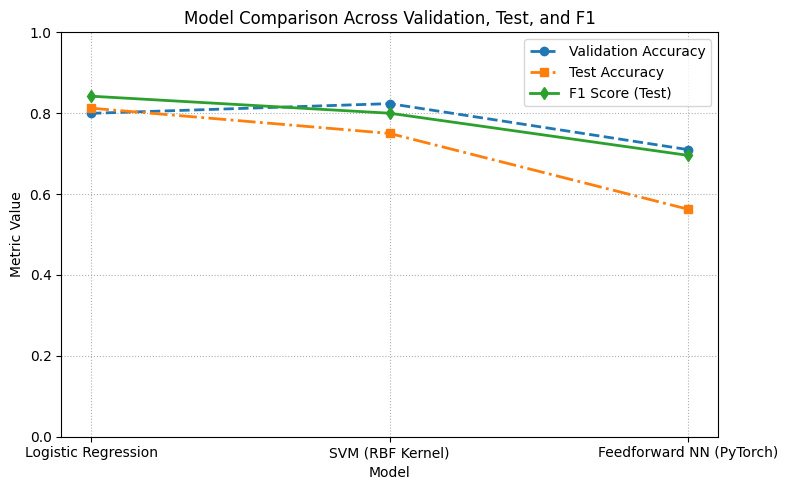

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import torch

dataset_info = {
    "Total Samples": len(X_train_df) + len(X_val_df) + len(X_test_df),
    "Train Samples": len(X_train_df),
    "Validation Samples": len(X_val_df),
    "Test Samples": len(X_test_df),
    "Feature Count": X_train_df.shape[1],
    "Class Distribution": {
        "No Pneumonia (0)": int((y_train_df == 0).sum() + (y_val_df == 0).sum() + (y_test_df == 0).sum()),
        "Pneumonia (1)": int((y_train_df == 1).sum() + (y_val_df == 1).sum() + (y_test_df == 1).sum())
    }
}

metrics = {}

# Logistic Regression
lr_val_preds = lr_model.predict(X_val_df)
lr_test_preds = lr_model.predict(X_test_df)
metrics["Logistic Regression"] = {
    "Validation Accuracy": accuracy_score(y_val_df, lr_val_preds),
    "Test Accuracy": accuracy_score(y_test_df, lr_test_preds),
    "F1 Score (Test)": f1_score(y_test_df, lr_test_preds)
}

# SVM
svm_val_preds = svm_model.predict(X_val_df)
svm_test_preds = svm_model.predict(X_test_df)
metrics["SVM (RBF Kernel)"] = {
    "Validation Accuracy": accuracy_score(y_val_df, svm_val_preds),
    "Test Accuracy": accuracy_score(y_test_df, svm_test_preds),
    "F1 Score (Test)": f1_score(y_test_df, svm_test_preds)
}

# FNN (PyTorch)
with torch.no_grad():
    fnn_val_preds = (model(torch.tensor(X_val_df.values, dtype=torch.float32)).numpy() > 0.5).astype(int)
    fnn_test_preds = (model(torch.tensor(X_test_df.values, dtype=torch.float32)).numpy() > 0.5).astype(int)

metrics["Feedforward NN (PyTorch)"] = {
    "Validation Accuracy": accuracy_score(y_val_df, fnn_val_preds),
    "Test Accuracy": accuracy_score(y_test_df, fnn_test_preds),
    "F1 Score (Test)": f1_score(y_test_df, fnn_test_preds)
}

results_df = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "Model"}).round(4)


print("Dataset Info:")
for k, v in dataset_info.items():
    print(f"{k}: {v}")

print("Model Performance Summary:")
display(results_df)

models = results_df['Model']

plt.figure(figsize=(8,5))
plt.plot(models, results_df['Validation Accuracy'], 'o--', linewidth=2, label='Validation Accuracy')
plt.plot(models, results_df['Test Accuracy'], 's-.', linewidth=2, label='Test Accuracy')
plt.plot(models, results_df['F1 Score (Test)'], 'd-', linewidth=2, label='F1 Score (Test)')

plt.title('Model Comparison Across Validation, Test, and F1')
plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.ylim(0, 1)
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()
